<h1><center>DSA 4212: Year 2019-2020</center></h1>
<h3><center> Assignment 1 (Deadline: 27 March 2020 at 23:59) </center></h3>
<h2><center> Group Number: 1 </center></h2>
<h2><center> Group Member 1: Joyce Lim Li Jie, A0173289R </center></h2>
<h2><center> Group Member 2: Ryan Teo Jin Chuan, A0164337A </center></h2>
<h2><center> Group Member 3: Wong Jia Hwee, A0166708W </center></h2>

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax; import jax.numpy as np

import pylab as plt
import imageio; import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
import pandas as pd; import time; import scipy

# 1. Data Pre-Processing

In [2]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

## 1.1 Creating training and validation datasets

We take the 15,000 training dataset and split it into a smaller training and validation dataset to improve the training outcome.

In [73]:
train = attribute[:15000]['Young']
test = attribute[15000:20000]['Young']

# subset training set by young/old
train_y = train[train==1] 
train_o = train[train==-1]

print("Proportion of old in dataset: {0:.3f}".format(len(train_o)/len(train)))

Proportion of old in dataset: 0.222


Of the 15,000 images in the training data, 3331 (22.2%) are old. We create the following subsets:

1. a balanced training set containing 80% (n=2665) of the old images and the same number of young images
2. a validation set that reflects the true proportion of old and young images. This contains 20% (n=666) of the old images and 2361 young images

In [4]:
n_train_o, n_val_o = 2665, 666
n_train_y, n_val_y = 2665, 2361

# select indices for prelim training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), n_train_y + n_val_y, replace=False)
o_pindex = onp.asarray(list(range(3331)))

# randomly assign sample to training or validation
ptrain_y = train_y.iloc[y_pindex[:n_train_y]]
pval_y = train_y.iloc[y_pindex[n_train_y:]]

ptrain_o = train_o.iloc[o_pindex[:n_train_o]]
pval_o = train_o.iloc[o_pindex[n_train_o:]]

# compile training data (5330 obs, 50% each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sample(frac=1) # shuffle training set

# compile validation data 
pval = pval_y.append(pval_o)
pval = pval.sample(frac=1) # shuffle validation set

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. 

`pval` is a 1 x 3027 array with the indicator values $\{-1, 1\}$ for old and young. 

## 1.2 Image Pre-Processing

The images were initially loaded in grayscale with their original size of 218 by 178 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [50:185, 40:135]. The resulting images used for analysis are 135 by 95 pixels.

In [16]:
h_n = 185-50 # height after cropping
w_n = 135-40 # width after cropping

# load and process the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h_n,w_n))

for k in range(len(ptrain)):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptrain_img[k,:,:] = im
    
# load and process the images from the prelim validation set
pval_ind = pval.index.values
pval_img = onp.zeros((len(pval),h_n,w_n))

for k in range(len(pval)):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    pval_img[k,:,:] = im
    
# load the images from the test set
#ntest_img = 5000
#ptest_img = onp.zeros((ntest_img,h_n,w_n))

#for k in range(ntest_img):
#    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
#    im = resize(im, (h,w))
#    im = onp.mean(im, axis=2) # grayscale
#    im = im/255. # rescale
#    im = im[50:185,40:135] # crop to face
#    ptest_img[k,:,:] = im

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. `ptrain_img` is a 5330 x 135 x 95 array that contains the relevant images for the preliminary training data. 

`pval` is a 1 x 3027 array with the indicator values $\{-1, 1\}$ for old and young. `pval_img`is a 1332 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

`test` is a 1 x 5000 array with with the indicator values $\{-1, 1\}$ for old and young. `ptest_img`is a 5000 x 135 x 95 array that contains the relevant images for the test data. 

In [9]:
data_train = ptrain_img.reshape(len(ptrain), h_n*w_n)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(len(pval), h_n*w_n)
y_val = pval.to_numpy(copy=True)

#data_test = ptest_img.reshape(5000, h_n*w_n)
#y_test = test.to_numpy(copy=True)

# 2. Optimisation

We optimise our logistic regression  model with a regularisation penalty.

* Logistic regression loss function with L2 penalty:
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{\lambda}{N} \| \beta \|^2$$

* Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

We define the loss, prediction, accuracy functions and vectorise them accordingly.

In [10]:
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def lossl2(beta, data, y, reg): # Ridge
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + reg*np.mean((beta)**2)

# grad_loss = jax.jit(jax.grad(loss))
grad_lossl2 = jax.jit(jax.grad(lossl2))

def accuracy(beta, data, y, threshold):
    pred = prediction_data(beta, data)
    prediction_binary = (pred > threshold).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

For each optimisation method, we plot the ROC curve and report the AUC.

In [11]:
# function to plot ROC curve
def plot_ROC(model, method, data, y):
    y_pred_proba = prediction_data(model,data)
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label=method+", AUC="+"{0:.3f}".format(auc))
    plt.legend(loc=4)
    plt.show()

Initialise $\beta \sim N(0, \frac{1}{\sqrt{D}})$ where $D=135*95$

In [112]:
# Initialise beta
D = h_n*w_n
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## 2.1 Baseline Classifier

Our model should beat a baseline classifier that classifies every person as young. Since the dataset is imbalanced, such a classifier is expected to have a test classification accuracy rate of 78.58%.

Accuracy: 0.77998017839445


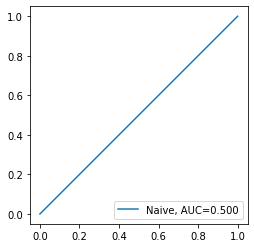

In [113]:
c = onp.ones(len(pval))
print("Accuracy:", sum(c==y_val)/len(pval))
    
plot_ROC(onp.ones(D), "Naive",data_val, y_val)

## 2.2 Stochastic Gradient Descent + Momentum

To test the various suitable values for $\lambda$ and an appropriate threshold, the loss function is minimised with stochastic gradient descent with the parameters specified below through a grid search.

In [ ]:
regs = [0, 0.1, 0.5, 1, 5] # lambdas to test
best_beta_sgdm = onp.zeros((len(regs),D)) # store the best models for each lambda
loss_train_hist = [[] for x in range(5)]
loss_val_hist = [[] for x in range(5)]

for i in range(len(regs)):
    print("Lambda:",regs[i])
    n_epoch = 100
    batch_size = 100  # size of the mini-batch
    mov_avg_param = 0.8 # added to smooth the loss graph
    learning_rate = 0.001

    #initialize the gradient
    beta = onp.copy(beta_init)
    gradient = grad_lossl2(beta, data_train, y_train, regs[i])

    start = time.time()
    for epoch in range(n_epoch):
        #let us divide the learning by 2 every 10 epoch
        if epoch % 10 == 0 and epoch >= 1:
            learning_rate = learning_rate/2.

        for k in range(ntrain_img // batch_size):  #number of batch per epoch
            #select at random "batch_size" random data point
            index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

            gradient_local = grad_lossl2(beta, data_train[index_], y_train[index_],regs[i])

            #moving average of the gradient
            gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

            #gradient descent update
            beta = beta - learning_rate * gradient

        loss_train = lossl2(beta, data_train, y_train, regs[i])
        loss_val = lossl2(beta, data_val, y_val, regs[i])

        if len(loss_val_hist[i])>0:
            if loss_val <= loss_val_hist[i][-1]:
                best_beta_sgdm[i] = beta # save the model with the lowest validation loss

        loss_train_hist[i].append(loss_train)
        loss_val_hist[i].append(loss_val)

        timing = time.time() - start
        if (epoch == 99) or not(epoch % 20):
            print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                     timing, 
                                                                                                    loss_train, 
                                                                                                    loss_val))

Text(0.5, 1.0, 'Stochastic Gradient Descent')

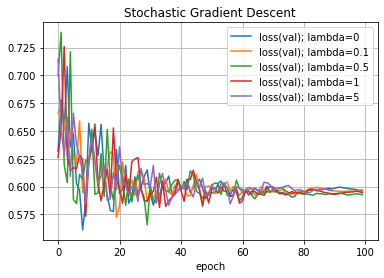

In [31]:
for i in range(len(regs)):
    plt.plot(loss_val_hist[i], label="loss(val); lambda="+str(regs[i]))
plt.legend(); plt.grid(True)
plt.xlabel("epoch"); plt.title("Stochastic Gradient Descent")

Validation losses for all the candidate $\lambda$'s converged.

In [33]:
# Calculate AUC and accuracy for grid search
acc_res = onp.zeros((10,(len(regs))))
auc_res = [[] for x in range(5)]

for i in range(len(regs)):
    best_beta = best_beta_sgdm[i]
    acc_list = []; auc_list = []
    for j in list(range(1,11)):
        acc = accuracy(best_beta, data_val, y_val, j/10)
        acc_list.append(acc)
    acc_res[:,i] = acc_list
    y_pred_proba = prediction_data(best_beta,data_val)
    fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
    auc = metrics.roc_auc_score(y_val, y_pred_proba)
    auc_res[i] = auc

In [42]:
# Display AUC by lambda
auc = pd.DataFrame(auc_res)
auc.columns = ['AUC']
auc.rename(index={0:0,1:0.1,2:0.5,3:1,4:5})

,AUC
0.0,0.738248
0.1,0.738517
0.5,0.739045
1.0,0.739549
5.0,0.738309


In [44]:
# Grid search to maximise accuracy by lambda and threshold
auc = pd.DataFrame(acc_res)
auc.columns = ['0','0.1','0.5','1','5']
auc.rename(index={0:0.1,1:0.2,2:0.3,3:0.4,4:0.5,5:0.6,6:0.7,7:0.8,8:0.9,9:1})

,0,0.1,0.5,1,5
0.1,0.779980,0.779980,0.779980,0.779980,0.779980
0.2,0.784936,0.785266,0.785266,0.785596,0.784936
0.3,0.795837,0.796829,0.797489,0.796168,0.797159
0.4,0.786587,0.785266,0.785596,0.786918,0.783944
0.5,0.693095,0.695078,0.701354,0.697060,0.699042
0.6,0.539808,0.545094,0.549389,0.545425,0.542451
0.7,0.365709,0.366369,0.370334,0.368352,0.365378
0.8,0.254708,0.255699,0.257351,0.256690,0.256029
0.9,0.221672,0.221341,0.222002,0.221341,0.222002
1.0,0.220020,0.220020,0.220020,0.220020,0.220020


From the tables above, it seems that AUC is highest when $\lambda=1$. The highest accuracy recorded is 0.797 when $\lambda = 1$ is when threshold = 0.3. This beats the naive model in both accuracy and AUC. The ROC is plotted below.

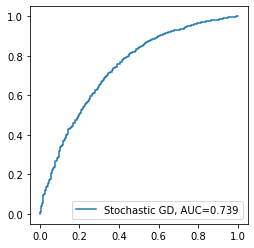

In [45]:
plot_ROC(best_beta_sgdm[2], "Stochastic GD", data_val, y_val)

## 2.3 L-BFGS

In [110]:
def loss_wrapper(beta):
    """ only one argument """
    return lossl2(beta, data_train, y_train, 1)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta))

In [ ]:
loss_train_bfgs = []; loss_val_bfgs = []
time_hist = []  # to save the compute time

best_beta_bfgs = onp.zeros(D) # to save best model
beta = onp.copy(beta_init)

def save_traj(beta):
    global best_beta_bfgs
    """ a function that saves a few statistics for later analysis"""
    loss_train = lossl2(beta, data_train, y_train, 1)
    loss_val = lossl2(beta, data_val, y_val, 1)
    timing = time.time() - start
    
    print("Time:{0:.3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    
    time_hist.append(timing)
    loss_train_bfgs.append(loss_train)
    loss_val_bfgs.append(loss_val)
    
    if loss_val <= loss_val_bfgs[-1]: # save the model with the lowest validation loss
        best_beta_bfgs = beta
        
#run LBFGS
start = time.time()
onp.random.seed(0)
traj = scipy.optimize.minimize(fun = loss_wrapper, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  # we want to use L-BFGS
                                jac=gradient_wrapper, # function that computes the gradient
                                callback=save_traj, # a function used to save some results for later plotting
                                options={"maxiter":100}) # maximum number of iterations

Text(0.5, 1.0, 'L-BFGS')

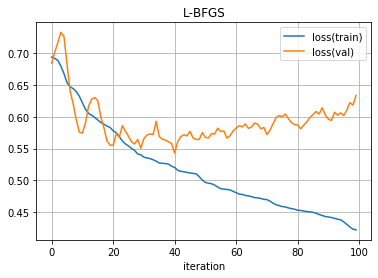

In [56]:
plt.plot(loss_train_bfgs, label="loss(train)")
plt.plot(loss_val_bfgs, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

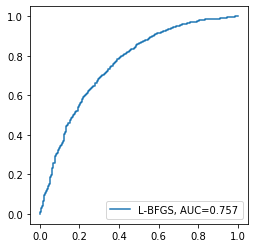

In [57]:
plot_ROC(best_beta_bfgs, "L-BFGS", data_val, y_val)

In [58]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_bfgs, data_val, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.807
Threshold: 0.2 	 Accuracy: 0.795
Threshold: 0.3 	 Accuracy: 0.775
Threshold: 0.4 	 Accuracy: 0.747
Threshold: 0.5 	 Accuracy: 0.710
Threshold: 0.6 	 Accuracy: 0.664
Threshold: 0.7 	 Accuracy: 0.606
Threshold: 0.8 	 Accuracy: 0.539
Threshold: 0.9 	 Accuracy: 0.427
Threshold: 1.0 	 Accuracy: 0.220


L-BFGS proved to have a higher AUC (0.757) and accuracy (0.807) than stochastic gradient descent. The highest accuracy is when threshold = 0.1, unlike with stochastic gradient descent. However, L-BFGS took a considerably longer time to run than SGD, taking almost twice the time.

# 3. Improvements to Images

This section will explore if the models can be improved by enhancing the pre-processing process - by using colored images or cropping the images to reduce memory space and run time.

## 3.1 Comparing colored images to grayscale

We load the images as `ptrain_imgc`, `pval_imgc`, `ptest_imgc` as the training, validation and test datasets respectively in color. This changes each image to a 135 by 95 by 3 array.

In [69]:
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_imgc = onp.zeros((ntrain_img,h_n,w_n,3))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptrain_imgc[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_imgc = onp.zeros((nval_img,h_n,w_n,3))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    pval_imgc[k,:,:] = im
    
# load the images from the test set
#ntest_img = 5000
#ptest_imgc = onp.zeros((ntest_img,h_n,w_n,3))

#for k in range(ntest_img):
#    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
#    im = im/255. # rescale
#    im = im[50:185,40:135] # crop to face
#    ptest_imgc[k,:,:] = im

In [96]:
# set datasets for colored images and initialise data
D = h_n*w_n*3

data_trainc = ptrain_imgc.reshape(5330, D)
y_train = ptrain.to_numpy(copy=True)

data_valc = pval_imgc.reshape(3027, D)
y_val = pval.to_numpy(copy=True)

#data_testc = ptest_imgc.reshape(5000, D)
#y_test = test.to_numpy(copy=True)

beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

The model is then trained with a stochastic gradient descent algorithm.

In [77]:
n_epoch = 100
batch_size = 100  # size of the mini-batch
mov_avg_param = 0.8 # added to smooth the loss graph
learning_rate = 0.001
loss_train_sgdmc = []; loss_val_sgdmc = []

#initialize the gradient
beta = onp.copy(beta_init)
gradient = grad_lossl2(beta, data_trainc, y_train, 1)
best_beta_sgdmc = onp.zeros(D) # best model

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        gradient_local = grad_lossl2(beta, data_trainc[index_], y_train[index_],1)

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = lossl2(beta, data_trainc, y_train,1)
    loss_val = lossl2(beta, data_valc, y_val,1)
    
    if len(loss_val_sgdmc)>0:
        if loss_val <= loss_val_sgdmc[-1]:
            best_beta_sgdmc = beta # save the model with the lowest validation loss
        
    loss_train_sgdmc.append(loss_train)
    loss_val_sgdmc.append(loss_val)
    
    timing = time.time() - start
    if (epoch == 99) or not(epoch % 20):
        print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:7 	 Loss(train):0.642 	 Loss(val):0.665
epoch:20 	 time:216 	 Loss(train):0.548 	 Loss(val):0.555
epoch:40 	 time:416 	 Loss(train):0.540 	 Loss(val):0.560
epoch:60 	 time:625 	 Loss(train):0.538 	 Loss(val):0.550
epoch:80 	 time:857 	 Loss(train):0.538 	 Loss(val):0.557
epoch:99 	 time:1054 	 Loss(train):0.538 	 Loss(val):0.556


Text(0.5, 1.0, 'Stochastic Gradient Descent on Colored')

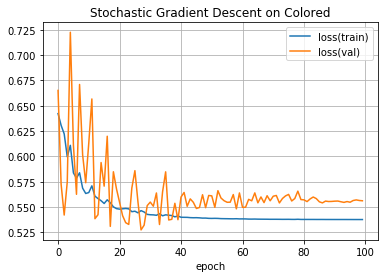

In [78]:
plt.plot(loss_train_sgdmc, label="loss(train)")
plt.plot(loss_val_sgdmc, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent on Colored")

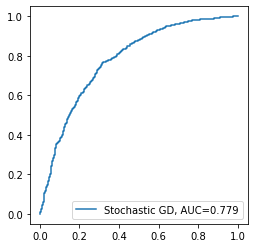

In [79]:
plot_ROC(best_beta_sgdmc, "Stochastic GD", data_valc, y_val)

In [80]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_sgdmc, data_valc, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.784
Threshold: 0.2 	 Accuracy: 0.807
Threshold: 0.3 	 Accuracy: 0.819
Threshold: 0.4 	 Accuracy: 0.790
Threshold: 0.5 	 Accuracy: 0.730
Threshold: 0.6 	 Accuracy: 0.616
Threshold: 0.7 	 Accuracy: 0.471
Threshold: 0.8 	 Accuracy: 0.327
Threshold: 0.9 	 Accuracy: 0.242
Threshold: 1.0 	 Accuracy: 0.220


Compared to using grayscale images, training the model on colored images improves the accuracy (81.9 at threshold 0.3) and AUC=0.779, at the cost of increasing the time spent by almost 3 times.

## 3.2 Comparing 'eyes only' to facial images

Observing the $\beta$'s from the best model generated below, it appears that areas near the eyes and the cheekbones have greater weight in determining if one is classified as young or old. This suggests that training the model on images cropped to this extent may result in some improvements to time.

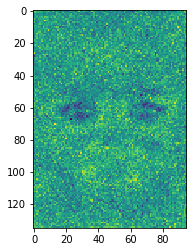

In [87]:
plt.imshow(onp.mean(best_beta_sgdmc.reshape(h_n,w_n,3),axis=2))

We load the images as `ptrain_imgce`, `pval_imgce`, `ptest_imgce` as the training, validation and test datasets respectively in color and crop the original images to the extent that includes only eyes and cheekbones. This changes each image to a $50*85*3$ array.

In [89]:
h_e, w_e = 145-95, 130-45
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_imgce = onp.zeros((ntrain_img,h_e,w_e,3))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = im/255. # rescale
    im = im[95:145,45:130] # crop to eyes
    ptrain_imgce[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_imgce = onp.zeros((nval_img,h_e,w_e,3))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = im/255. # rescale
    im = im[95:145,45:130] # crop to eyes
    pval_imgce[k,:,:] = im
    
# load the images from the test set
#ntest_img = 5000
#ptest_imgce = onp.zeros((ntest_img,h_e,w_e,3))

#for k in range(ntest_img):
#    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
#    im = im/255. # rescale
#    im = im[95:145,45:130] # crop to face
#    ptest_imgce[k,:,:] = im

In [91]:
D = h_e*w_e*3

data_traince = ptrain_imgce.reshape(5330, D)
y_train = ptrain.to_numpy(copy=True)

data_valce = pval_imgce.reshape(3027, D)
y_val = pval.to_numpy(copy=True)

#data_testce = ptest_imgce.reshape(5000, D)
#y_test = test.to_numpy(copy=True)

beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

The model is trained with a stochastic gradient descent algorithm.

In [92]:
n_epoch = 100
batch_size = 100  # size of the mini-batch
mov_avg_param = 0.8 # added to smooth the loss graph
learning_rate = 0.001
loss_train_sgdmce = []; loss_val_sgdmce = []

#initialize the gradient
beta = onp.copy(beta_init)
gradient = grad_lossl2(beta, data_traince, y_train,1)
best_beta_sgdmce = onp.zeros(D) # best model

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        gradient_local = grad_lossl2(beta, data_traince[index_], y_train[index_],1)

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = lossl2(beta, data_traince, y_train,1)
    loss_val = lossl2(beta, data_valce, y_val,1)
    
    if len(loss_val_sgdmce)>0:
        if loss_val <= loss_val_sgdmce[-1]:
            best_beta_sgdmce = beta # save the model with the lowest validation loss
        
    loss_train_sgdmce.append(loss_train)
    loss_val_sgdmce.append(loss_val)
    
    timing = time.time() - start
    if (epoch == 99) or not(epoch % 20):
        print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:3 	 Loss(train):0.666 	 Loss(val):0.661
epoch:20 	 time:72 	 Loss(train):0.594 	 Loss(val):0.593
epoch:40 	 time:137 	 Loss(train):0.588 	 Loss(val):0.591
epoch:60 	 time:205 	 Loss(train):0.586 	 Loss(val):0.590
epoch:80 	 time:273 	 Loss(train):0.586 	 Loss(val):0.596
epoch:99 	 time:338 	 Loss(train):0.586 	 Loss(val):0.595


Text(0.5, 1.0, 'Stochastic Gradient Descent on Eyes')

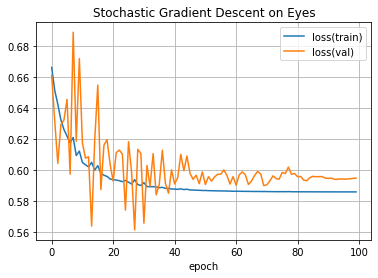

In [93]:
plt.plot(loss_train_sgdmce, label="loss(train)")
plt.plot(loss_val_sgdmce, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent on Eyes")

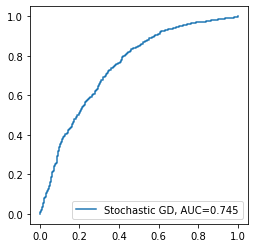

In [94]:
# function to plot ROC curve
plot_ROC(best_beta_sgdmce, "Stochastic GD", data_valce, y_val)

In [95]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_sgdmce, data_valce, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.780
Threshold: 0.2 	 Accuracy: 0.781
Threshold: 0.3 	 Accuracy: 0.803
Threshold: 0.4 	 Accuracy: 0.784
Threshold: 0.5 	 Accuracy: 0.695
Threshold: 0.6 	 Accuracy: 0.547
Threshold: 0.7 	 Accuracy: 0.387
Threshold: 0.8 	 Accuracy: 0.273
Threshold: 0.9 	 Accuracy: 0.230
Threshold: 1.0 	 Accuracy: 0.220


This results in an accuracy of 0.803 with a threshold of 0.3, which beats the naive model. However, this has a lower AUC and accuracy compared to model in section 3.1 trained on the full-face colored images. This suggests that information is lost from removing parts of the images outside the eyes. Nonetheless, this method still has some merit given the reduction in time by more than 60%.

# 4. Conclusion

Combining the method that returned the highest accuracy (L-BFGS) and full colored images, we present the best model below.

In [99]:
def loss_wrapper2(beta):
    """ only one argument """
    return lossl2(beta, data_trainc, y_train, 1)

grad_loss_wrapper2 = jax.jit(jax.grad(loss_wrapper2))    

def gradient_wrapper2(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper2(beta))

In [106]:
loss_train_bfgs2 = []; loss_val_bfgs2 = []
time_hist = []  # to save the compute time

best_beta_bfgs2 = onp.zeros(D) # to save best model
beta = onp.copy(beta_init)

def save_traj(beta):
    global best_beta_bfgs2
    """ a function that saves a few statistics for later analysis"""
    loss_train = lossl2(beta, data_trainc, y_train, 1)
    loss_val = lossl2(beta, data_valc, y_val, 1)
    timing = time.time() - start
    
    print("Time:{0:.3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    
    time_hist.append(timing)
    loss_train_bfgs2.append(loss_train)
    loss_val_bfgs2.append(loss_val)
    
    if loss_val <= loss_val_bfgs2[-1]: # save the model with the lowest validation loss
        best_beta_bfgs2 = beta
        
#run LBFGS
start = time.time()
onp.random.seed(0)
traj = scipy.optimize.minimize(fun = loss_wrapper2, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  # we want to use L-BFGS
                                jac=gradient_wrapper2, # function that computes the gradient
                                callback=save_traj, # a function used to save some results for later plotting
                                options={"maxiter":100}) # maximum number of iterations

Time:39.675 	 Loss(train):0.702 	 Loss(val):0.712
Time:58.677 	 Loss(train):0.700 	 Loss(val):0.702
Time:77.994 	 Loss(train):0.684 	 Loss(val):0.640
Time:97.369 	 Loss(train):0.670 	 Loss(val):0.617
Time:116.654 	 Loss(train):0.652 	 Loss(val):0.629
Time:136.066 	 Loss(train):0.643 	 Loss(val):0.657
Time:152.257 	 Loss(train):0.638 	 Loss(val):0.671
Time:167.923 	 Loss(train):0.629 	 Loss(val):0.683
Time:185.276 	 Loss(train):0.618 	 Loss(val):0.676
Time:203.176 	 Loss(train):0.594 	 Loss(val):0.632
Time:220.571 	 Loss(train):0.579 	 Loss(val):0.588
Time:237.895 	 Loss(train):0.577 	 Loss(val):0.578
Time:255.193 	 Loss(train):0.575 	 Loss(val):0.577
Time:281.743 	 Loss(train):0.574 	 Loss(val):0.560
Time:299.157 	 Loss(train):0.570 	 Loss(val):0.563
Time:316.542 	 Loss(train):0.561 	 Loss(val):0.567
Time:334.127 	 Loss(train):0.553 	 Loss(val):0.573
Time:351.666 	 Loss(train):0.549 	 Loss(val):0.568
Time:382.624 	 Loss(train):0.548 	 Loss(val):0.574
Time:401.022 	 Loss(train):0.545 	 

Text(0.5, 1.0, 'L-BFGS')

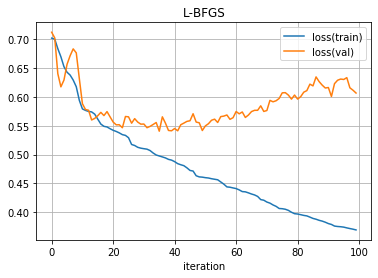

In [107]:
plt.plot(loss_train_bfgs2, label="loss(train)")
plt.plot(loss_val_bfgs2, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

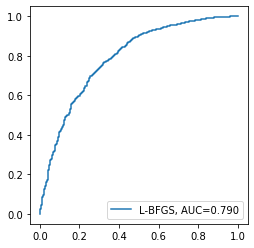

In [108]:
plot_ROC(best_beta_bfgs2, "L-BFGS", data_valc, y_val)

In [109]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_bfgs2, data_valc, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.818
Threshold: 0.2 	 Accuracy: 0.813
Threshold: 0.3 	 Accuracy: 0.787
Threshold: 0.4 	 Accuracy: 0.755
Threshold: 0.5 	 Accuracy: 0.727
Threshold: 0.6 	 Accuracy: 0.686
Threshold: 0.7 	 Accuracy: 0.642
Threshold: 0.8 	 Accuracy: 0.579
Threshold: 0.9 	 Accuracy: 0.476
Threshold: 1.0 	 Accuracy: 0.220


After training on colored images, L-BFGS proved to have a higher AUC (0.79) and accuracy (0.818 at threshold = 0.1) than with just grayscale images. While the accuracy for this seems slightly lower than the model trained in 3.1 on SGD, it has a marginally larger AUC and thus has more confidence. Thus, the final model proposed by our group is to train the colored images cropped to the facial extent on L-BFGS.